# Entity type clustering

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from gensim import downloader
from tabulate import tabulate

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

from umap import UMAP
from hdbscan import HDBSCAN

import dist_util as util

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/davidsule/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/davidsule/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Manual Clustering

In [2]:
manual_categories = {
    "person" :      ["politician", "person", "writer", "researcher", "scientist", "musicalartist"],
    "organisation": ["organisation", "politicalparty", "university", "band"],
    "location":     ["country", "location"],
    "event":        ["event", "election", "award", "conference"],
    "artifact":     ["album", "song", "academicjournal", "poem", "magazine", "book"],
    "scientific":   ["metrics", "enzyme", "protein", "chemicalcompound", "chemicalelement", "astronomicalobject"],
    "concept":      ["theory", "musicgenre", "field", "discipline", "algorithm", "literarygenre"],
    "brand":        ["product", "programlang"],
    "misc":         ["misc", "musicalinstrument", "task"]
}

elisa_categories = {
    "person":       ["politician", "person", "writer", "researcher", "scientist", "musicalartist"],
    "organisation": ["organisation", "politicalparty", "university", "band"],
    "location":     ["country", "location"],
    "event":        ["event", "election", "conference"],
    "misc":         ["award", "album", "song", "academicjournal", "poem", "magazine", "book", "metrics", "enzyme", "protein", "chemicalcompound", "chemicalelement", "astronomicalobject", "theory", "musicgenre", "field", "discipline", "algorithm", "literarygenre", "product", "programlang", "misc", "musicalinstrument", "task"]
}

## Embedding based - Word2Vec

In [3]:
# Avoid downloading / loading the whole Word2Vec Google News 300 model
# If True, category names won't be calculated and files won't be written.
quick = False
category_map_csv_path = "../data/category_mappings.csv"

# Labels (Manual copy from .env file)
entities_orig = "academicjournal album algorithm astronomicalobject award band book chemicalcompound chemicalelement conference country discipline election enzyme event field literarygenre location magazine metrics misc musicalartist musicalinstrument musicgenre organisation person poem politicalparty politician product programlang protein researcher scientist song task theory university writer"
entities_orig = entities_orig.split()

if quick:
    entities = ['journal', 'album', 'algorithm', 'galaxy', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'genre', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'violin', 'organization', 'person', 'poem', 'coalition', 'politician', 'product', 'javascript', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']
    embeddings = np.loadtxt("embeddings.csv", delimiter=",", dtype="float32")
    print("3D plot and category list will be created, but w/o category names and files won't be written.")
else:

    # Load Word2Vec embeddings - First time download: ~1.6 GB
    print("Loading pretrained Word2Vec model, this may take a while.")
    w2v = downloader.load("word2vec-google-news-300")

    # Check which words are not in Word2Vec model
    missing = util.find_missing(w2v, entities_orig)
    print(f"These entities are not in the model:\n{missing}")

Loading pretrained Word2Vec model, this may take a while.
These entities are not in the model:
['academicjournal', 'astronomicalobject', 'chemicalcompound', 'chemicalelement', 'literarygenre', 'musicalartist', 'musicalinstrument', 'musicgenre', 'organisation', 'politicalparty', 'programlang']


In [4]:
if not quick:
    # Manual correction
    substitute = {"musicalartist": "musician", "organisation": "organization", "politicalparty": "coalition", "academicjournal": "journal", "chemicalcompound": "chemical", "chemicalelement": "chemical", "astronomicalobject": "galaxy", "musicgenre": "genre", "literarygenre": "genre", "programlang": "javascript", "musicalinstrument": "violin", "misc": "miscellaneous"}
    entities = []
    for entity in entities_orig:
        if entity in substitute:
            to_add = substitute[entity]
        else:
            to_add = entity
        if to_add not in entities:
            entities.append(to_add)

    still_missing = util.find_missing(w2v, entities)
    if len(still_missing) > 0:
        print("These entities are not in the model:")
        print(still_missing)
    else:
        print("All entities are in the model. Final list:\n")
        print(entities)
        print("\nLoading embeddings for them.")
        embeddings = w2v[entities]
        print("Done. Saving embeddings.")
        np.savetxt("embeddings.csv", embeddings, delimiter=",")

All entities are in the model. Final list:

['journal', 'album', 'algorithm', 'galaxy', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'genre', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'violin', 'organization', 'person', 'poem', 'coalition', 'politician', 'product', 'javascript', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']

Loading embeddings for them.
Done. Saving embeddings.


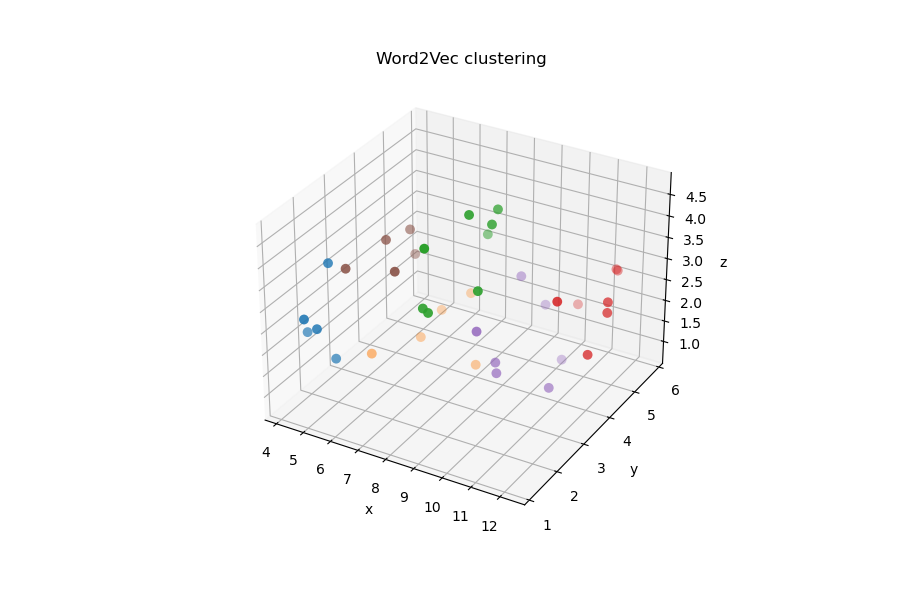


Calculating label names, this might take a few sec.

The final categories are:
----------  -------------------------------------------------------------------------------------------------------------------------
essay       ['academicjournal', 'book', 'magazine', 'poem', 'theory']
songs       ['album', 'band', 'musicgenre', 'literarygenre', 'musicalinstrument', 'song']
proteins    ['algorithm', 'astronomicalobject', 'chemicalcompound', 'chemicalelement', 'enzyme', 'metrics', 'programlang', 'protein']
convention  ['award', 'conference', 'election', 'event', 'location', 'organisation', 'person', 'politicalparty']
TELW        ['country', 'discipline', 'field', 'misc', 'product', 'task', 'university']
journalist  ['musicalartist', 'politician', 'researcher', 'scientist', 'writer']
----------  -------------------------------------------------------------------------------------------------------------------------


In [5]:
# Tuned vars
random_state = 4012
n_neighbors = 4
min_dist = 0.3
damping = 0.5

pipe = Pipeline([
    ("PCA", PCA(n_components=35, svd_solver="full")),
    ("UMAP", UMAP(n_neighbors=n_neighbors, n_components=3, metric="cosine", min_dist=min_dist, random_state=random_state)),
    ("Clusterer", AffinityPropagation(damping=damping, random_state=random_state))
])
pred = pipe.fit_predict(embeddings)

# Plot
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] for x in pred]
%matplotlib widget
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
coordinates = pipe[0:2].transform(embeddings)
plot = ax.scatter3D(coordinates[:,0], coordinates[:,1], coordinates[:,2], c=cluster_colors, s=50, linewidth=0)
ax.set_title("Word2Vec clustering")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Category names
categories = util.categories_from_pred(pred, entities)
# for fun
categories_oldnames = deepcopy(categories)
if not quick:
    print("\nCalculating label names, this might take a few sec.")
    categories = util.entities_to_orig(util.name_categories(categories, w2v), substitute)
    embedding_categories = categories
else:
    print("Set `quick` to False to get named categories. Defaulting to unnamed labels.")
    embedding_categories = None
print("\nThe final categories are:")
print(tabulate([[category, elements] for category, elements in categories.items()]))

In [6]:
# For fun: with the old naming function (avoids too similar names + doesn't remove names with special chars)
if not quick:
    print("This is mostly for fun because I liked the quirky names of the old way I did the category naming.\n")
    categories_5th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=5), substitute)
    categories_6th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=6), substitute)
    print(tabulate([[category, elements] for category, elements in categories_5th.items()]))
    print(tabulate([[category, elements] for category, elements in categories_6th.items()]))

This is mostly for fun because I liked the quirky names of the old way I did the category naming.

-----------------------  -------------------------------------------------------------------------------------------------------------------------
essays                   ['academicjournal', 'book', 'magazine', 'poem', 'theory']
tunes                    ['album', 'band', 'musicgenre', 'literarygenre', 'musicalinstrument', 'song']
molecules                ['algorithm', 'astronomicalobject', 'chemicalcompound', 'chemicalelement', 'enzyme', 'metrics', 'programlang', 'protein']
executive_Ellen_Ziffren  ['award', 'conference', 'election', 'event', 'location', 'organisation', 'person', 'politicalparty']
XKSD_What                ['country', 'discipline', 'field', 'misc', 'product', 'task', 'university']
historian                ['musicalartist', 'politician', 'researcher', 'scientist', 'writer']
-----------------------  ---------------------------------------------------------------------------

## Thesaurus-based categories - WordNet

### Topological

In [7]:
# Manual Correction
substitute = {"musicalartist": "musician", "organisation": "organization", "politicalparty": "party", "academicjournal": "journal", "chemicalcompound": "chemical", "chemicalelement": "chemical", "astronomicalobject": "galaxy", "musicgenre": "genre", "literarygenre": "genre", "programlang": "java", "musicalinstrument": "instrument", "misc": "miscellaneous"}
entities = set()
for entity in entities_orig:
    if entity in substitute:
        entities.add(substitute[entity])
    else:
        entities.add(entity)

entities = list(entities)
entities.sort()
print(entities)

['album', 'algorithm', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'galaxy', 'genre', 'instrument', 'java', 'journal', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'organization', 'party', 'person', 'poem', 'politician', 'product', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']


In [8]:
# Get categories with most frequent word meanings
# util.category_dict(most_frequent_synset(entities), 2, entities)

In [9]:
# Check meanings and definitions for manual correction
idx = 36
synlist = wordnet.synsets(entities[idx])
print(idx, entities[idx])
for i, syn in enumerate(synlist):
    print(i, syn, syn.definition())

36 writer
0 Synset('writer.n.01') writes (books or stories or articles or the like) professionally (for pay)
1 Synset('writer.n.02') a person who is able to write and has written something


In [10]:
# Manual corrections of meanings. Key: idx in Entity_labels, value: idx of meaning in wordnet.synsets(word)
# check: To check whether entities are the same as the list the meaning dict was made on
check = ['album', 'algorithm', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'galaxy', 'genre', 'instrument', 'java', 'journal', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'organization', 'party', 'person', 'poem', 'politician', 'product', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']
if entities != check:
    raise ValueError("entities modified since meaning_dict was edited!")
meaning_dict = {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 3, 13: 2, 14: 0, 15: 5, 16: 2, 17: 1, 18: 0, 19: 0, 20: 3, 21: 0, 22: 0, 23: 2, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 1, 34: 0, 35: 2, 36: 0}

In [11]:
# Get categories with associated words
entity_syns = []
for i, word in enumerate(entities):
    entity_syns.append(wordnet.synsets(word)[meaning_dict[i]])
topological_categories = util.topological_category_dict(entity_syns, 2, entities)
topological_categories = util.entities_to_orig(topological_categories, substitute)
print("\nThe final categories are:")
print(tabulate([[category, elements] for category, elements in topological_categories.items()]))


The final categories are:
---------------------  ----------------------------------------------------------------------------------------------------------
object                 ['album', 'book', 'musicalinstrument', 'academicjournal', 'location', 'magazine', 'product']
psychological_feature  ['algorithm', 'discipline', 'election', 'event', 'field', 'musicgenre', 'literarygenre', 'task', 'theory']
communication          ['award', 'programlang', 'poem', 'song']
group                  ['band', 'conference', 'country', 'astronomicalobject', 'organisation', 'politicalparty', 'university']
matter                 ['chemicalcompound', 'chemicalelement', 'enzyme']
measure                ['metrics']
assorted               ['misc']
causal_agent           ['musicalartist', 'person', 'politician', 'researcher', 'scientist', 'writer']
thing                  ['protein']
---------------------  ----------------------------------------------------------------------------------------------------------

### Affinity-based

In [12]:
# Calculate Wu-Palmer Similarities
similarities = util.get_wup_sim(entity_syns)
# Affinity Propagation
damping = 0.5 # [0.5, 1.0)
ap = AffinityPropagation(damping=damping, affinity="precomputed", random_state=random_state)
ap = ap.fit_predict(similarities)

# Category names
categories = util.categories_from_pred(ap, entities)
# for fun
categories_oldnames = deepcopy(categories)
if not quick:
    print("\nCalculating label names, this might take a few sec.")
    categories = util.entities_to_orig(util.name_categories(categories, w2v), substitute)
    thesaurus_similarity_categories = categories
else:
    print("Set `quick` to False to get named categories. Defaulting to unnamed labels.")
    thesaurus_similarity_categories = None
print("\nThe final categories are:")
print(tabulate([[category, elements] for category, elements in categories.items()]))


Calculating label names, this might take a few sec.

The final categories are:
----------  -----------------------------------------------------------------------------------------------------------------------------
journals    ['album', 'book', 'musicalinstrument', 'academicjournal', 'magazine', 'product']
pleiotropy  ['algorithm', 'discipline', 'election', 'event', 'field', 'musicgenre', 'literarygenre', 'metrics', 'misc', 'task', 'theory']
poems       ['award', 'programlang', 'poem', 'song']
group       ['band', 'conference', 'country', 'astronomicalobject', 'organisation', 'politicalparty', 'university']
enzymes     ['chemicalcompound', 'chemicalelement', 'enzyme', 'protein']
journalist  ['location', 'musicalartist', 'person', 'politician', 'researcher', 'scientist', 'writer']
----------  -----------------------------------------------------------------------------------------------------------------------------


In [13]:
# For fun: with the old naming function (avoids too similar names + doesn't remove names with special chars)
if not quick:
    print("This is mostly for fun because I liked the quirky names of the old way I did the category naming.\n")
    categories_5th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=5), substitute)
    categories_6th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=6), substitute)
    print(tabulate([[category, elements] for category, elements in categories_5th.items()]))
    print(tabulate([[category, elements] for category, elements in categories_6th.items()]))

This is mostly for fun because I liked the quirky names of the old way I did the category naming.

------------------  -----------------------------------------------------------------------------------------------------------------------------
anthology           ['album', 'book', 'musicalinstrument', 'academicjournal', 'magazine', 'product']
By_Tatyana_Shumsky  ['algorithm', 'discipline', 'election', 'event', 'field', 'musicgenre', 'literarygenre', 'metrics', 'misc', 'task', 'theory']
lyrics              ['award', 'programlang', 'poem', 'song']
Hal_Kratzsch        ['band', 'conference', 'country', 'astronomicalobject', 'organisation', 'politicalparty', 'university']
biochemical         ['chemicalcompound', 'chemicalelement', 'enzyme', 'protein']
songwriter          ['location', 'musicalartist', 'person', 'politician', 'researcher', 'scientist', 'writer']
------------------  ---------------------------------------------------------------------------------------------------------------

In [14]:
# This was just a test - We can use it if we can argue why this over Affinity
# Propagation if we used that for the word2vec
from hdbscan import HDBSCAN
distances = 1 - similarities
hdb = HDBSCAN(min_cluster_size=2, min_samples=2, cluster_selection_epsilon=0, metric="precomputed")
hdb = hdb.fit_predict(distances)

categories = util.categories_from_pred(hdb, entities)
# for fun
categories_oldnames = deepcopy(categories)
if -1 in categories:
    print(f"Entities categorized as noise:\n{categories[-1]}")
if not quick:
    print("\nCalculating label names, this might take a few sec.")
    categories = util.entities_to_orig(util.name_categories(categories, w2v), substitute)
    hdb_thesaurus_similarity_categories = categories
else:
    print("Set `quick` to False to get named categories. Defaulting to unnamed labels.")
    hdb_thesaurus_similarity_categories = None
print("\nThe final categories are:")
print(tabulate([[category, elements] for category, elements in categories.items()]))

Entities categorized as noise:
['location', 'metrics', 'miscellaneous']

Calculating label names, this might take a few sec.

The final categories are:
-----------  ----------------------------------------------------------------------------------------------------------
tome         ['album', 'book', 'academicjournal', 'magazine']
pedagogies   ['algorithm', 'discipline', 'election', 'event', 'field', 'musicgenre', 'literarygenre', 'task', 'theory']
poems        ['award', 'programlang', 'poem', 'song']
group        ['band', 'conference', 'country', 'astronomicalobject', 'organisation', 'politicalparty', 'university']
enzymes      ['chemicalcompound', 'chemicalelement', 'enzyme', 'protein']
instruments  ['musicalinstrument', 'product']
locations    ['location', 'metrics', 'misc']
journalist   ['musicalartist', 'person', 'politician', 'researcher', 'scientist', 'writer']
-----------  ---------------------------------------------------------------------------------------------------------

In [15]:
# For fun: with the old naming function (avoids too similar names + doesn't remove names with special chars)
if not quick:
    print("This is mostly for fun because I liked the quirky names of the old way I did the category naming.\n")
    categories_5th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=5), substitute)
    categories_6th = util.entities_to_orig(util.name_categories_old(categories_oldnames, w2v, kth_closest=6), substitute)
    print(tabulate([[category, elements] for category, elements in categories_5th.items()]))
    print(tabulate([[category, elements] for category, elements in categories_6th.items()]))

This is mostly for fun because I liked the quirky names of the old way I did the category naming.

---------------  ----------------------------------------------------------------------------------------------------------
autobiography    ['album', 'book', 'academicjournal', 'magazine']
unfair_Fredline  ['algorithm', 'discipline', 'election', 'event', 'field', 'musicgenre', 'literarygenre', 'task', 'theory']
lyrics           ['award', 'programlang', 'poem', 'song']
Hal_Kratzsch     ['band', 'conference', 'country', 'astronomicalobject', 'organisation', 'politicalparty', 'university']
biochemical      ['chemicalcompound', 'chemicalelement', 'enzyme', 'protein']
SourceMeter      ['musicalinstrument', 'product']
TrimFleet        ['location', 'metrics', 'misc']
physicist        ['musicalartist', 'person', 'politician', 'researcher', 'scientist', 'writer']
---------------  ----------------------------------------------------------------------------------------------------------
-----------

## Write to file

In [16]:
# Only if category names are assigned
if not quick:
    # check if everything matches
    entities_orig.sort()
    category_types = [manual_categories, elisa_categories, embedding_categories, topological_categories, thesaurus_similarity_categories]
    for category_type in category_types:
        tmp = []
        for values in category_type.values():
            tmp += values
        tmp.sort()
        if tmp != entities_orig:
            raise ValueError("Entities don't match across categorization methods.")

    # Dict with entities as keys and the list of category names as values
    # corresponding to the order in category_types
    entity_dict = {}
    for category_type in category_types:
        for category, entities in category_type.items():
            for entity in entities:
                if entity in entity_dict:
                    entity_dict[entity].append(category)
                else:
                    entity_dict[entity] = [category]
    
    cols = ["manual", "elisa", "embedding", "topological", "thesaurus_similarity"]
    category_df = pd.DataFrame.from_dict(entity_dict, orient="index", columns=cols)
    category_df.index.name = "entity_name"
    os.makedirs(os.path.dirname(category_map_csv_path), exist_ok=True)
    category_df.to_csv(category_map_csv_path)
